In [1]:
!pip install torch torcheeg -q

In [2]:
import numpy as np
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms
from torcheeg.datasets.constants import SEED_CHANNEL_LOCATION_DICT

In [3]:
import shutil
import os

# Copy cached data to a writable path (once per run)
src = '/kaggle/input/seed-files/datasets_1747078356366_RtGOr'
dst = '/kaggle/working/datasets_1747078356366_RtGOr'

if not os.path.exists(dst):
    shutil.copytree(src, dst)

In [4]:
# Now load using the new writable path
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms
from torcheeg.datasets.constants import SEED_CHANNEL_LOCATION_DICT

dataset = SEEDDataset(
    root_path='/kaggle/input/seed-files/Preprocessed_EEG/Preprocessed_EEG',
    io_path=dst,
    offline_transform=transforms.Compose([
        transforms.BandDifferentialEntropy(),
        transforms.ToGrid(SEED_CHANNEL_LOCATION_DICT)
    ]),
    online_transform=None,
    label_transform=transforms.Compose([
        transforms.Select('emotion'),
        transforms.Lambda(lambda x: x + 1)
    ])
)
print(dataset[0])

[2025-05-13 21:25:16] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from /kaggle/working/datasets_1747078356366_RtGOr.


(array([[[ 0.        ,  0.        ,  0.        ,  5.1831583 ,
          5.08873149,  4.98068051,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  4.55525121,
          0.        ,  4.26426878,  0.        ,  0.        ,
          0.        ],
        [ 4.20135545,  4.00987461,  3.80647291,  3.8589796 ,
          3.78275299,  3.71949033,  3.32898481,  3.86598276,
          3.5137544 ],
        [ 3.55742278,  3.83699458,  3.147277  ,  3.13136814,
          3.44546163,  2.8614765 ,  2.86054707,  3.19966734,
          4.49792072],
        [ 3.8301178 ,  3.7472155 ,  3.48729206,  2.92998403,
         -0.54599075,  2.45030623,  3.20566034,  3.73924968,
          4.57854672],
        [ 3.86204248,  3.53517754,  3.44241738,  3.12258819,
         -0.65328288,  2.36070512,  3.87596423,  4.04731902,
          4.44037432],
        [ 3.92828057,  3.79930761,  3.6489857 ,  4.59850318,
          3.14233341,  3.50695212,  3.83876585,  4.36317202,
       

In [5]:
eeg, label = dataset[0]
print(eeg.shape)

(4, 9, 9)


🔄 Collecting features...
✅ Total samples: 152730, Feature dimension: 324
🎯 Applying t-SNE...


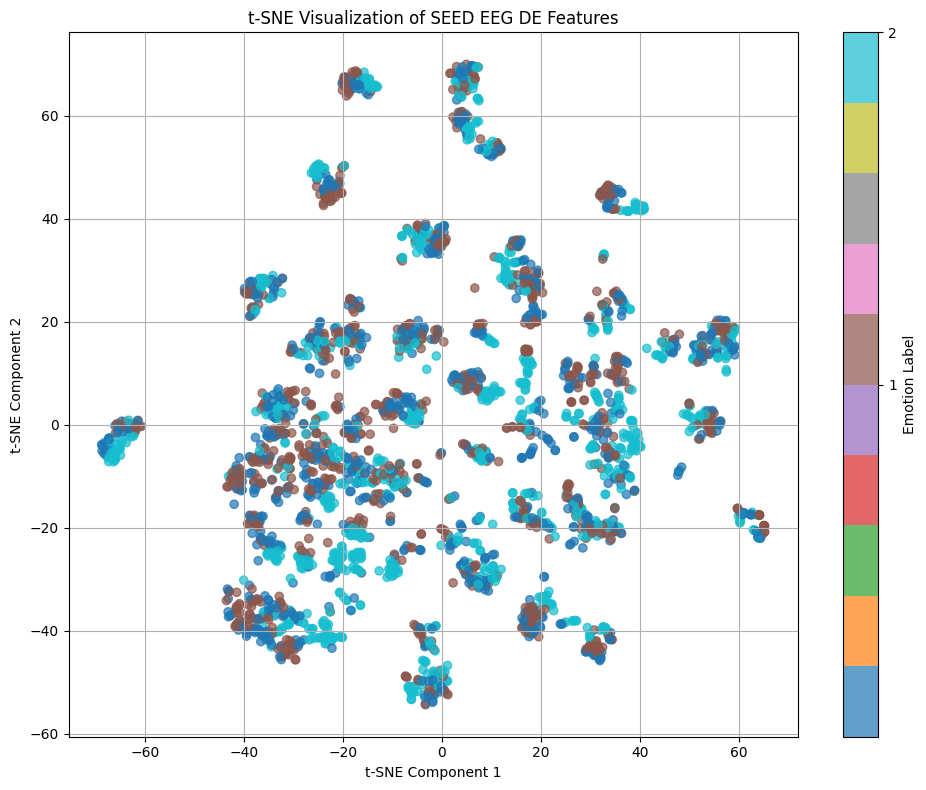

📂 t-SNE plot saved to: /kaggle/working/tsne_seed_eeg.png


In [6]:
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

all_features = []
all_labels = []

print("🔄 Collecting features...")
with torch.no_grad():
    for eeg_signals, labels in dataloader:
        # Flatten from (4, 9, 9) → (324,)
        features = eeg_signals.view(eeg_signals.size(0), -1).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate all features and labels
X = np.concatenate(all_features, axis=0)
y = np.concatenate(all_labels, axis=0)

print(f"✅ Total samples: {X.shape[0]}, Feature dimension: {X.shape[1]}")

# Downsample for t-SNE
sample_size = min(3000, len(X))
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

print("🎯 Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_sampled = tsne.fit_transform(X_sample)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_sampled[:, 0], X_tsne_sampled[:, 1], c=y_sample, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=[1, 2, 3], label='Emotion Label')
plt.title('t-SNE Visualization of SEED EEG DE Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.tight_layout()

# Save figure
save_path = '/kaggle/working/tsne_seed_eeg.png'
plt.savefig(save_path, dpi=300)
plt.show()

print(f"📂 t-SNE plot saved to: {save_path}")

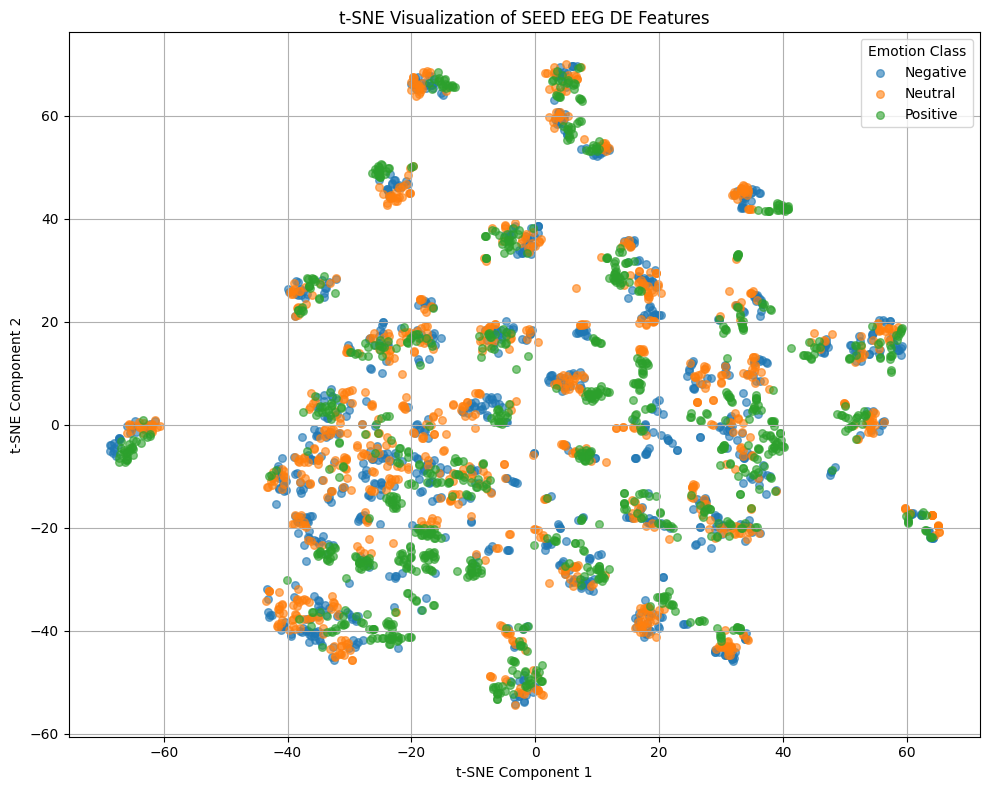

✅ Updated t-SNE plot saved to: /kaggle/working/tsne_seed_eeg_labeled.png


In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np
import torch

# Assuming `X_sample`, `y_sample` already computed from previous t-SNE steps

# Map emotion labels to names
label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 8))

for i, label in enumerate([0, 1, 2]):
    idxs = y_sample == label
    plt.scatter(X_tsne_sampled[idxs, 0], X_tsne_sampled[idxs, 1],
                label=label_names[label], alpha=0.6, s=30)

plt.title('t-SNE Visualization of SEED EEG DE Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.legend(title="Emotion Class")
plt.tight_layout()

# Save and show
save_path = '/kaggle/working/tsne_seed_eeg_labeled.png'
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Updated t-SNE plot saved to: {save_path}")

## START OF MSCL

In [71]:
# ✅ Step 1: Setup and Imports-
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms
from torcheeg.datasets.constants import SEED_CHANNEL_LOCATION_DICT
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [72]:
# ✅ Step 2: Load Dataset with torcheeg
seed_dataset = SEEDDataset(
    root_path='/kaggle/input/seed-files/Preprocessed_EEG/Preprocessed_EEG',
    io_path='/kaggle/working/datasets_1747078356366_RtGOr',  # writable path
    offline_transform=transforms.Compose([
        transforms.BandDifferentialEntropy(),
        transforms.ToGrid(SEED_CHANNEL_LOCATION_DICT)
    ]),
    online_transform=None,
    label_transform=transforms.Compose([
        transforms.Select('emotion'),
        transforms.Lambda(lambda x: x + 1)  # 1 = Negative, 2 = Neutral, 3 = Positive
    ])
)

[2025-05-13 22:31:48] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from /kaggle/working/datasets_1747078356366_RtGOr.


In [73]:
# ✅ Step 3: Flatten (4, 9, 9) → (324,) + Create trial list
all_data = []
for i in range(len(seed_dataset)):
    eeg, label = seed_dataset[i]
    subject = i // 60  # Each subject has 15 videos × 4 trials → ~60
    feature = eeg.reshape(-1)  # shape (324,)
    all_data.append({
        'feature': feature,
        'label': label,
        'subject': subject
    })

print("✅ Feature shape:", all_data[0]['feature'].shape)
print("✅ Label:", all_data[0]['label'], "Subject:", all_data[0]['subject'])

✅ Feature shape: (324,)
✅ Label: 2 Subject: 0


In [74]:
# ✅ Step 4: Subject-wise stratified splitting
from collections import defaultdict
import random
random.seed(42)
train_set, val_set, test_set = [], [], []

for subject in set(x['subject'] for x in all_data):
    subj_trials = [x for x in all_data if x['subject'] == subject]
    label_groups = defaultdict(list)
    for trial in subj_trials:
        label_groups[trial['label']].append(trial)
    for label, trials in label_groups.items():
        random.shuffle(trials)
        n = len(trials)
        split1, split2 = int(0.6 * n), int(0.8 * n)
        train_set.extend(trials[:split1])
        val_set.extend(trials[split1:split2])
        test_set.extend(trials[split2:])

print(len(train_set))

91170


In [75]:
print("Length of train set: ",len(train_set))
print("Length of val set: ",len(val_set))
print("Length of test set: ",len(test_set))

Length of train set:  91170
Length of val set:  30546
Length of test set:  31014


In [76]:
# ✅ Step 5: Normalize features based on training set
scaler = StandardScaler()
train_features = np.vstack([x['feature'] for x in train_set])
scaler.fit(train_features)

for data_split in [train_set, val_set, test_set]:
    for x in data_split:
        x['feature'] = scaler.transform(x['feature'].reshape(1, -1)).flatten()

In [77]:
# ✅ Step 6: Dataset and DataLoader
class EEGDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx]['feature'], dtype=torch.float32)
        y = self.data[idx]['label']
        return x, y

def get_sampler(dataset):
    labels = np.array([x['label'] - 1 for x in dataset if x['label'] > 0])  # Filter out any invalid labels
    labels = labels[labels >= 0]  # Ensure all are non-negative
    class_weights = 1. / np.bincount(labels)
    weights = class_weights[labels]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

batch_size = 64
train_loader = DataLoader(EEGDataset(train_set), batch_size=batch_size, sampler=get_sampler(train_set))
val_loader = DataLoader(EEGDataset(val_set), batch_size=batch_size)
test_loader = DataLoader(EEGDataset(test_set), batch_size=batch_size)

# ✅ CUDA Check
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [16]:
labels = [x[1] for x in EEGDataset(train_set)]
print("Min:", min(labels), "Max:", max(labels), "Set:", set(labels))  # Expected: {0, 1, 2}

Min: 0 Max: 2 Set: {0, 1, 2}


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSupConEncoder(nn.Module):
    def __init__(self, input_dim=324, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128)
        )
        self.projector = nn.Sequential(
            nn.Linear(128, projection_dim),
            nn.LeakyReLU(0.01),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = F.normalize(self.projector(h), dim=1)
        return h, z

In [18]:
class PrototypeContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1)
        unique_classes = labels.unique()

        # Skip if only one class
        if len(unique_classes) < 2:
            return torch.tensor(0.0, device=device)

        # Prototypes
        prototypes = {}
        for c in unique_classes:
            mask = labels == c
            prototypes[c.item()] = features[mask].mean(dim=0)

        proto_classes = torch.tensor(list(prototypes.keys()), device=device)
        proto_features = torch.stack(list(prototypes.values()))
        features_norm = F.normalize(features, dim=1)
        proto_features_norm = F.normalize(proto_features, dim=1)

        sim = torch.matmul(features_norm, proto_features_norm.T) / self.temperature

        # Target indices
        target_indices = [(proto_classes == l).nonzero().item() for l in labels]
        target_indices = torch.tensor(target_indices, device=device)

        return F.cross_entropy(sim, target_indices)

In [19]:
class MMDLoss(nn.Module):
    def __init__(self, bandwidth=1.0):
        super().__init__()
        self.bandwidth = bandwidth

    def gaussian_kernel(self, x, y):
        x, y = x[:min(len(x), len(y))], y[:min(len(x), len(y))]  # match sizes
        xx, yy, xy = x @ x.T, y @ y.T, x @ y.T
        rx = xx.diag().unsqueeze(1).expand_as(xx)
        ry = yy.diag().unsqueeze(0).expand_as(yy)
        dxx = rx + rx.T - 2 * xx
        dyy = ry + ry.T - 2 * yy
        dxy = rx + ry.T - 2 * xy
        return (
            torch.exp(-dxx / (2 * self.bandwidth ** 2)),
            torch.exp(-dyy / (2 * self.bandwidth ** 2)),
            torch.exp(-dxy / (2 * self.bandwidth ** 2))
        )

    def forward(self, source, target):
        if source.size(0) < 2 or target.size(0) < 2:
            return torch.tensor(0.0, device=source.device)
        kxx, kyy, kxy = self.gaussian_kernel(source, target)
        return kxx.mean() + kyy.mean() - 2 * kxy.mean()

In [20]:
def train_epoch(encoder, loader, optimizer, l_con, mmd_loss_fn, mmd_weight, device):
    encoder.train()
    total_loss, valid_batches = 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        _, z = encoder(x)
        if z.size(0) < 4: continue

        z, y = z[:z.size(0) // 2 * 2], y[:z.size(0) // 2 * 2]  # make even
        half = z.size(0) // 2
        z_s, z_t = z[:half], z[half:]

        loss_con = l_con(z, y)
        loss_mmd = mmd_loss_fn(z_s, z_t)
        loss = loss_con + mmd_weight * loss_mmd

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        valid_batches += 1

    return total_loss / valid_batches if valid_batches > 0 else 0.0


def validate(encoder, loader, l_con, mmd_loss_fn, mmd_weight, device):
    encoder.eval()
    total_loss, valid_batches = 0.0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _, z = encoder(x)
            if z.size(0) < 4: continue

            z, y = z[:z.size(0) // 2 * 2], y[:z.size(0) // 2 * 2]
            half = z.size(0) // 2
            z_s, z_t = z[:half], z[half:]

            loss = l_con(z, y) + mmd_weight * mmd_loss_fn(z_s, z_t)
            total_loss += loss.item()
            valid_batches += 1

    return total_loss / valid_batches if valid_batches > 0 else 0.0

In [21]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = ImprovedSupConEncoder(input_dim=324, projection_dim=128).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-5)
l_con2 = PrototypeContrastiveLoss()
mmd_loss = MMDLoss(bandwidth=1.0)
mmd_weight = 0.2

# Training loop
best_val_loss = float('inf')
patience, counter = 15, 0
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss = train_epoch(encoder, train_loader, optimizer, l_con2, mmd_loss, mmd_weight, device)
    val_loss = validate(encoder, val_loader, l_con2, mmd_loss, mmd_weight, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(encoder.state_dict(), 'best_encoder.pt')
        print("✅ Saved best model")
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping")
            break

Epoch 1/100 | Train: 0.4685 | Val: 0.3164
✅ Saved best model
Epoch 2/100 | Train: 0.3327 | Val: 0.3037
✅ Saved best model
Epoch 3/100 | Train: 0.2798 | Val: 0.3117
Epoch 4/100 | Train: 0.2530 | Val: 0.3067
Epoch 5/100 | Train: 0.2305 | Val: 0.3292
Epoch 6/100 | Train: 0.2164 | Val: 0.3114
Epoch 7/100 | Train: 0.2017 | Val: 0.3176
Epoch 8/100 | Train: 0.1923 | Val: 0.3072
Epoch 9/100 | Train: 0.1802 | Val: 0.3096
Epoch 10/100 | Train: 0.1738 | Val: 0.3099
Epoch 11/100 | Train: 0.1660 | Val: 0.2993
✅ Saved best model
Epoch 12/100 | Train: 0.1577 | Val: 0.3000
Epoch 13/100 | Train: 0.1516 | Val: 0.2926
✅ Saved best model
Epoch 14/100 | Train: 0.1480 | Val: 0.2867
✅ Saved best model
Epoch 15/100 | Train: 0.1408 | Val: 0.2997
Epoch 16/100 | Train: 0.1379 | Val: 0.2913
Epoch 17/100 | Train: 0.1332 | Val: 0.2954
Epoch 18/100 | Train: 0.1352 | Val: 0.2839
✅ Saved best model
Epoch 19/100 | Train: 0.1297 | Val: 0.2803
✅ Saved best model
Epoch 20/100 | Train: 0.1272 | Val: 0.2860
Epoch 21/100 | T

In [22]:
from sklearn.metrics import classification_report
def evaluate(encoder, loader, device):
    encoder.eval()
    X, y = [], []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            h, _ = encoder(x_batch)
            X.append(h.cpu().numpy())
            y.append(y_batch.numpy())

    X = np.vstack(X)
    y = np.concatenate(y)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    
    print("Classification report",classification_report(y, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    print("\n")
    return {
        'accuracy': accuracy_score(y, y_pred),
        'f1_score': f1_score(y, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y, y_pred),
    }

# Load best model and evaluate
encoder.load_state_dict(torch.load('best_encoder.pt'))
test_metrics = evaluate(encoder, test_loader, device)

print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print("Confusion Matrix:\n", test_metrics['confusion_matrix'])

Classification report               precision    recall  f1-score   support

    Negative       0.73      0.72      0.72     10224
     Neutral       0.73      0.73      0.73     10116
    Positive       0.88      0.89      0.88     10674

    accuracy                           0.78     31014
   macro avg       0.78      0.78      0.78     31014
weighted avg       0.78      0.78      0.78     31014



Test Accuracy: 0.7813
F1 Score: 0.7808
Confusion Matrix:
 [[7369 2123  732]
 [2156 7349  611]
 [ 589  573 9512]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

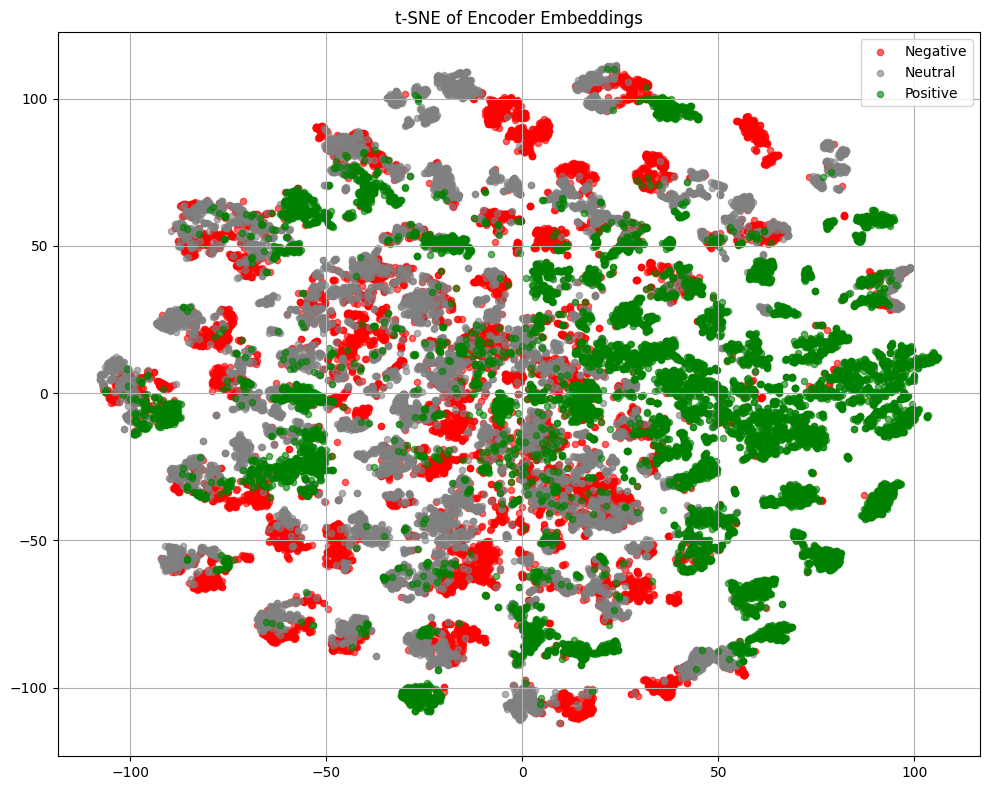

In [24]:
def visualize_embeddings(encoder, loader, device, title="t-SNE of Encoder Embeddings"):
    encoder.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            h, _ = encoder(x)
            embeddings.append(h.cpu().numpy())
            labels.append(y.numpy())

    X = np.vstack(embeddings)
    y = np.concatenate(labels)

    # 🔒 Filter only valid labels (0, 1, 2)
    mask = np.isin(y, [0, 1, 2])
    X = X[mask]
    y = y[mask]

    # Reduce to 2D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)

    # Define names and colors
    label_names = ['Negative', 'Neutral', 'Positive']
    colors = ['red', 'gray', 'green']

    plt.figure(figsize=(10, 8))
    for i, name in enumerate(label_names):
        idx = y == i
        if np.any(idx):  # only plot if there are samples for the label
            plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=name, alpha=0.6, s=20)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('tsne_embeddings_emotion.png', dpi=300)
    plt.show()


visualize_embeddings(encoder, test_loader, device)

In [25]:
def evaluate_per_subject(encoder, test_data, device):
    encoder.eval()
    subjects = sorted(set(x['subject'] for x in test_data))
    results = {}

    for subj in subjects:
        subj_data = [x for x in test_data if x['subject'] == subj]
        loader = DataLoader(EEGDataset(subj_data), batch_size=64)
        
        embeddings, labels = [], []
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                h, _ = encoder(x)
                embeddings.append(h.cpu().numpy())
                labels.append(y.numpy())

        X = np.vstack(embeddings)
        y = np.concatenate(labels)

        if len(np.unique(y)) < 2:
            continue  # Skip subjects with only 1 class

        clf = LogisticRegression(max_iter=1000)
        clf.fit(X, y)
        y_pred = clf.predict(X)

        results[subj] = {
            'accuracy': accuracy_score(y, y_pred),
            'f1_score': f1_score(y, y_pred, average='weighted'),
            'samples': len(y)
        }

    return results

subject_metrics = evaluate_per_subject(encoder, test_set, device)
print("📊 Subject-wise Accuracy & F1:")
for s, m in subject_metrics.items():
    print(f"Subject {s:2d} | Acc: {m['accuracy']:.4f} | F1: {m['f1_score']:.4f} | N={m['samples']}")

📊 Subject-wise Accuracy & F1:
Subject  3 | Acc: 1.0000 | F1: 1.0000 | N=12
Subject  7 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 15 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 18 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 21 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 25 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 29 | Acc: 1.0000 | F1: 1.0000 | N=12
Subject 37 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 41 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 45 | Acc: 1.0000 | F1: 1.0000 | N=12
Subject 49 | Acc: 1.0000 | F1: 1.0000 | N=12
Subject 53 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 56 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 60 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 64 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 71 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 74 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 78 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 82 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 85 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 94 | Acc: 1.0000 | F1: 1.0000 | N=13
Subject 97 | Acc: 1.0000 

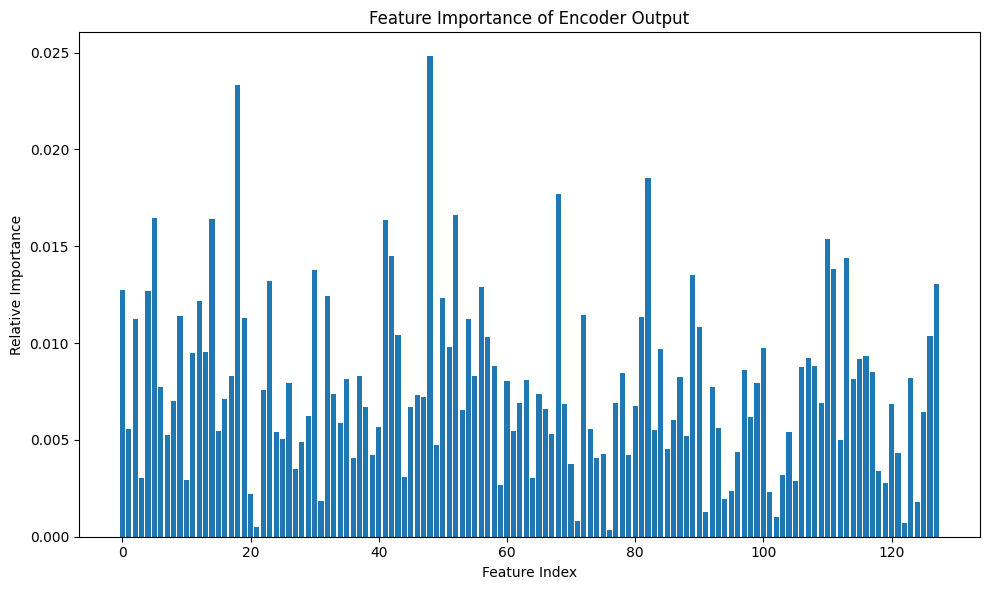

In [26]:
def analyze_feature_importance(encoder, loader, device):
    encoder.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            h, _ = encoder(x)
            embeddings.append(h.cpu().numpy())
            labels.append(y.numpy())

    X = np.vstack(embeddings)
    y = np.concatenate(labels)

    # Fit L1-regularized Logistic Regression
    clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    clf.fit(X, y)
    importance = np.abs(clf.coef_).sum(axis=0)
    normalized_importance = importance / importance.sum()

    return normalized_importance

importance_scores = analyze_feature_importance(encoder, test_loader, device)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance_scores)), importance_scores)
plt.title("Feature Importance of Encoder Output")
plt.xlabel("Feature Index")
plt.ylabel("Relative Importance")
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()


In [27]:
import numpy as np

accs = [v['accuracy'] for v in subject_metrics.values()]
f1s = [v['f1_score'] for v in subject_metrics.values()]
print(f"\n📌 Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"📌 Mean F1 Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


📌 Mean Accuracy: 1.0000 ± 0.0000
📌 Mean F1 Score: 1.0000 ± 0.0000


## MLP + GCE

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# ✅ GCE Loss Function
class GeneralizedCrossEntropyLoss(nn.Module):
    def __init__(self, q=0.7):
        super().__init__()
        self.q = q

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        probs = torch.clamp(probs, min=1e-6, max=1.0)
        probs_correct = probs.gather(1, targets.unsqueeze(1)).squeeze()
        loss = (1.0 - probs_correct ** self.q) / self.q
        return loss.mean()

In [30]:
# ✅ MLP Classifier Model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=324, hidden_dim=128, num_classes=3):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = self.hidden(x)
        out = self.classifier(h)
        return out

    def extract_features(self, x):
        return self.hidden(x)


In [31]:
# ✅ Training Loop

def train_classifier(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [32]:
# ✅ Validation / Test Function

def evaluate_classifier(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, f1, cm, classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'])

In [33]:
# ✅ Phase 3 Execution

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(input_dim=324).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = GeneralizedCrossEntropyLoss(q=0.7)

train_loader_cls = DataLoader(EEGDataset(train_set), batch_size=64, shuffle=True)
val_loader_cls = DataLoader(EEGDataset(val_set), batch_size=64)
test_loader_cls = DataLoader(EEGDataset(test_set), batch_size=64)

best_val_loss = float('inf')
patience = 10
counter = 0
train_losses, val_losses = [], []

for epoch in range(100):
    train_loss = train_classifier(model, train_loader_cls, optimizer, criterion, device)
    val_loss = train_classifier(model, val_loader_cls, optimizer, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mlp_gce.pt')
        counter = 0
        print("✅ Best model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

Epoch 1 | Train Loss: 0.4340 | Val Loss: 0.4272
✅ Best model saved.
Epoch 2 | Train Loss: 0.3506 | Val Loss: 0.3815
✅ Best model saved.
Epoch 3 | Train Loss: 0.3274 | Val Loss: 0.3555
✅ Best model saved.
Epoch 4 | Train Loss: 0.3097 | Val Loss: 0.3397
✅ Best model saved.
Epoch 5 | Train Loss: 0.2987 | Val Loss: 0.3244
✅ Best model saved.
Epoch 6 | Train Loss: 0.2896 | Val Loss: 0.3197
✅ Best model saved.
Epoch 7 | Train Loss: 0.2824 | Val Loss: 0.3094
✅ Best model saved.
Epoch 8 | Train Loss: 0.2759 | Val Loss: 0.2986
✅ Best model saved.
Epoch 9 | Train Loss: 0.2708 | Val Loss: 0.2926
✅ Best model saved.
Epoch 10 | Train Loss: 0.2652 | Val Loss: 0.2919
✅ Best model saved.
Epoch 11 | Train Loss: 0.2596 | Val Loss: 0.2825
✅ Best model saved.
Epoch 12 | Train Loss: 0.2565 | Val Loss: 0.2765
✅ Best model saved.
Epoch 13 | Train Loss: 0.2522 | Val Loss: 0.2777
Epoch 14 | Train Loss: 0.2484 | Val Loss: 0.2722
✅ Best model saved.
Epoch 15 | Train Loss: 0.2452 | Val Loss: 0.2618
✅ Best model s

In [34]:
# ✅ Evaluation on Test Set
model.load_state_dict(torch.load('best_mlp_gce.pt'))
acc, f1, cm, report = evaluate_classifier(model, test_loader_cls, device)

print("\n📊 MLP + GCE Evaluation on Test Set")
print(f"Test Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


📊 MLP + GCE Evaluation on Test Set
Test Accuracy: 0.8615
F1 Score: 0.8624
Confusion Matrix:
 [[8743 1174  307]
 [1212 8660  244]
 [ 713  646 9315]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.86      0.84     10224
     Neutral       0.83      0.86      0.84     10116
    Positive       0.94      0.87      0.91     10674

    accuracy                           0.86     31014
   macro avg       0.86      0.86      0.86     31014
weighted avg       0.86      0.86      0.86     31014



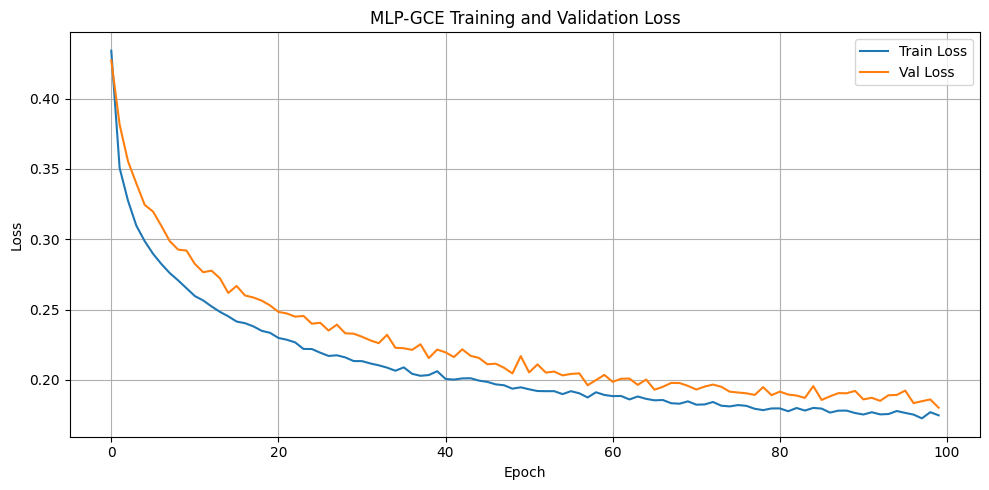

In [35]:
# ✅ Training Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('MLP-GCE Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mlp_gce_training_curve.png')
plt.show()


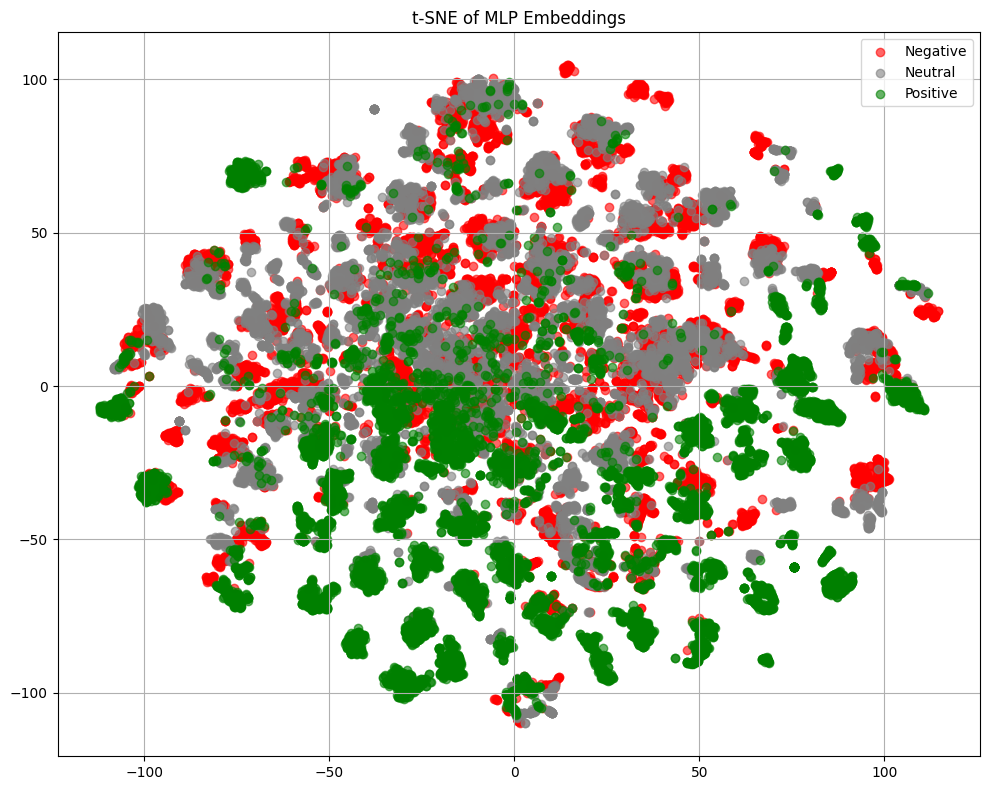

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_mlp_embeddings(model, loader, device, title="t-SNE of MLP Embeddings"):
    model.eval()
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            h = model.extract_features(x)  # (batch, 128)
            all_embs.append(h.cpu().numpy())
            all_labels.append(y.numpy())

    X = np.vstack(all_embs)
    y = np.concatenate(all_labels)

    # t-SNE
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 8))
    label_names = ['Negative', 'Neutral', 'Positive']
    colors = ['red', 'gray', 'green']
    for i, name in enumerate(label_names):
        idx = y == i
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=name, alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("tsne_mlp_embeddings.png", dpi=300)
    plt.show()

visualize_mlp_embeddings(model, test_loader_cls, device)

## Fine Tuning

In [37]:
class EncoderWithClassifier(nn.Module):
    def __init__(self, encoder, hidden_dim=128, num_classes=3):
        super().__init__()
        self.encoder = encoder  # pretrained encoder (frozen/unfrozen)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h, _ = self.encoder(x)
        return self.classifier(h)

In [38]:
# Load encoder
encoder = ImprovedSupConEncoder(input_dim=324, projection_dim=128)
encoder.load_state_dict(torch.load('best_encoder.pt'))

# Wrap in fine-tune model
finetune_model = EncoderWithClassifier(encoder).to(device)

In [39]:
def evaluate_classifier(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'])

    return acc, f1, cm, report

In [40]:
def freeze_encoder(model, freeze=True):
    for param in model.encoder.parameters():
        param.requires_grad = not freeze

In [44]:
def train_finetune_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [45]:
def train_finetune(
    model, train_loader, val_loader,
    optimizer, criterion, device,
    freeze_epochs=10, total_epochs=100,
    patience=15, checkpoint_path='finetuned_encoder.pt'
):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(total_epochs):
        # Freeze encoder for first `freeze_epochs`
        if epoch == freeze_epochs:
            print("🔓 Unfreezing encoder from epoch", epoch)
            freeze_encoder(model, freeze=False)

        train_loss = train_finetune_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = train_finetune_epoch(model, val_loader, optimizer, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            counter = 0
            print("✅ Best model saved.")
        else:
            counter += 1
            if counter >= patience:
                print("⛔ Early stopping triggered.")
                break

    return train_losses, val_losses

In [46]:
# Wrap encoder and classifier
finetune_model = EncoderWithClassifier(encoder).to(device)
freeze_encoder(finetune_model, freeze=True)  # Start frozen

# Optimizer and loss
optimizer = torch.optim.Adam(finetune_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = GeneralizedCrossEntropyLoss(q=0.7)

# Train
train_losses, val_losses = train_finetune(
    model=finetune_model,
    train_loader=train_loader_cls,
    val_loader=val_loader_cls,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    freeze_epochs=10,
    total_epochs=100,
    patience=15,
    checkpoint_path='finetuned_encoder.pt'
)

Epoch 1 | Train Loss: 0.3461 | Val Loss: 0.6639
✅ Best model saved.
Epoch 2 | Train Loss: 0.3272 | Val Loss: 0.6643
Epoch 3 | Train Loss: 0.3233 | Val Loss: 0.6636
✅ Best model saved.
Epoch 4 | Train Loss: 0.3215 | Val Loss: 0.6647
Epoch 5 | Train Loss: 0.3206 | Val Loss: 0.6644
Epoch 6 | Train Loss: 0.3199 | Val Loss: 0.6646
Epoch 7 | Train Loss: 0.3195 | Val Loss: 0.6640
Epoch 8 | Train Loss: 0.3191 | Val Loss: 0.6640
Epoch 9 | Train Loss: 0.3179 | Val Loss: 0.6647
Epoch 10 | Train Loss: 0.3177 | Val Loss: 0.6644
🔓 Unfreezing encoder from epoch 10
Epoch 11 | Train Loss: 0.2389 | Val Loss: 0.6712
Epoch 12 | Train Loss: 0.2064 | Val Loss: 0.6280
✅ Best model saved.
Epoch 13 | Train Loss: 0.1943 | Val Loss: 0.5960
✅ Best model saved.
Epoch 14 | Train Loss: 0.1839 | Val Loss: 0.5680
✅ Best model saved.
Epoch 15 | Train Loss: 0.1751 | Val Loss: 0.5470
✅ Best model saved.
Epoch 16 | Train Loss: 0.1653 | Val Loss: 0.5230
✅ Best model saved.
Epoch 17 | Train Loss: 0.1621 | Val Loss: 0.5150
✅

In [47]:
# Load best model and evaluate
finetune_model.load_state_dict(torch.load('finetuned_encoder.pt'))
acc, f1, cm, report = evaluate_classifier(finetune_model, test_loader_cls, device)
print(f"\nTest Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Test Accuracy: 0.5460 | F1 Score: 0.5264
Confusion Matrix:
 [[6669 3490   65]
 [2721 7360   35]
 [4018 3752 2904]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.50      0.65      0.56     10224
     Neutral       0.50      0.73      0.60     10116
    Positive       0.97      0.27      0.42     10674

    accuracy                           0.55     31014
   macro avg       0.66      0.55      0.53     31014
weighted avg       0.66      0.55      0.53     31014



In [48]:
import matplotlib.pyplot as plt

def plot_finetuning_loss(train_losses, val_losses, title="Fine-Tuning Loss Curve", save_path="finetuned_loss_plot.png"):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

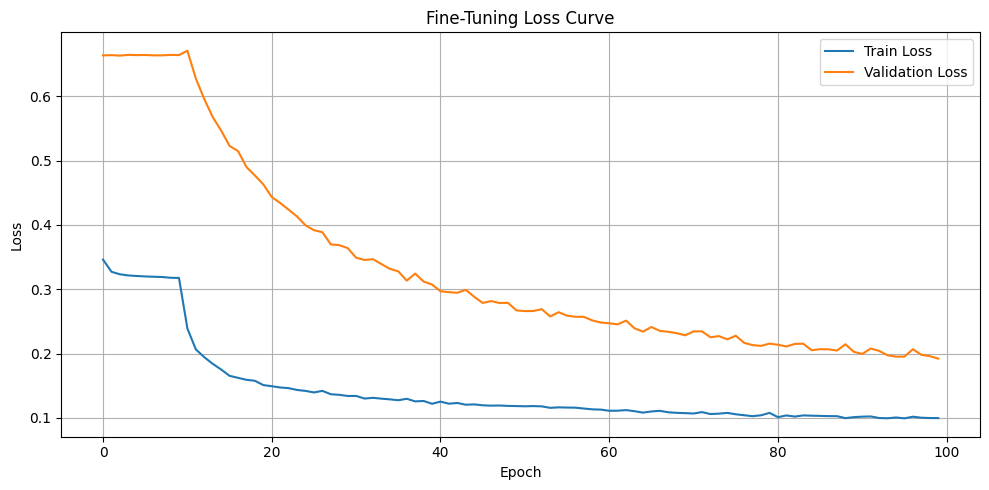

In [49]:
plot_finetuning_loss(train_losses, val_losses)

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_finetuned_embeddings(model, loader, device, save_path="finetuned_tsne.png"):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            h, _ = model.encoder(x)  # Use encoder to get h (not logits)
            embeddings.append(h.cpu().numpy())
            labels.append(y.numpy())

    X = np.vstack(embeddings)
    y = np.concatenate(labels)

    # t-SNE dimensionality reduction
    X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)

    # Plotting
    label_names = ['Negative', 'Neutral', 'Positive']
    colors = ['red', 'gray', 'green']
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(label_names):
        idx = y == i
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[i], label=label, alpha=0.6)

    plt.title("t-SNE of Fine-Tuned Encoder Embeddings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


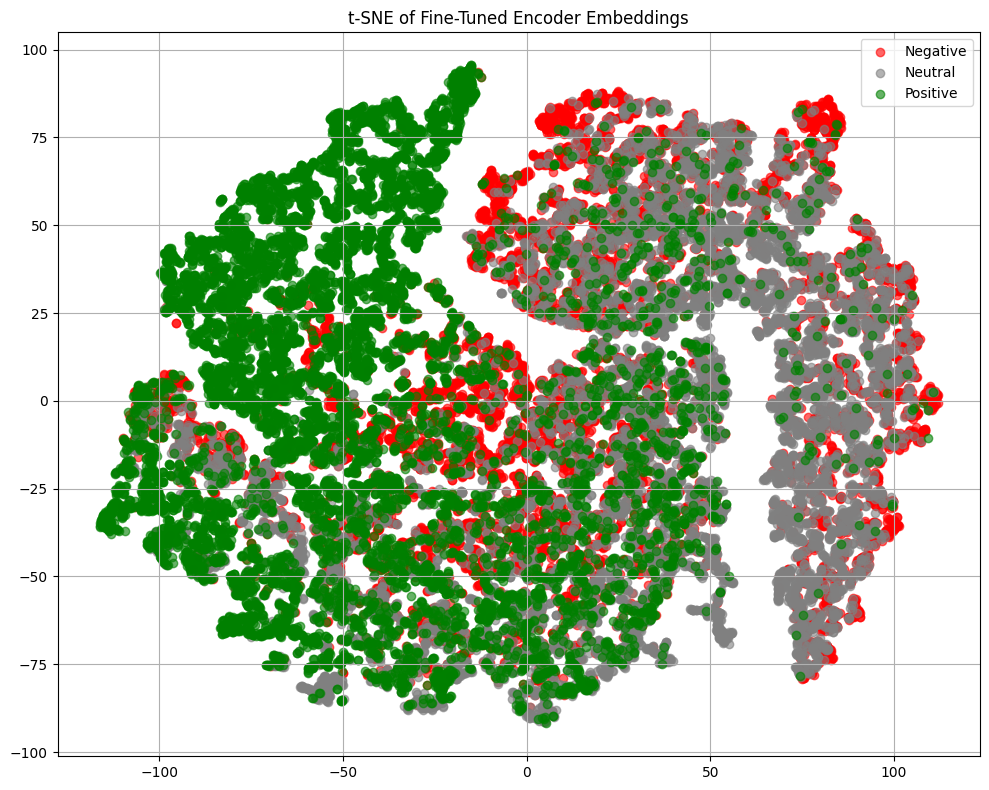

In [51]:
finetune_model.load_state_dict(torch.load('finetuned_encoder.pt'))
visualize_finetuned_embeddings(finetune_model, test_loader_cls, device)